In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [30]:
# standard library imports
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import keras

In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
from matplotlib.font_manager import FontProperties

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [4]:
# Check Versions
print(tf.__version__)  # 1.15.0
print(keras.__version__)  # 2.2.4

1.15.0
2.2.4


# The SRGN fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at generator-level (before detector simulation) while the fit happens in simulation (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at simulation-level or both happen at generator-level.  This notebook illustrates the alternative SRGN procedure from (*insert link here*):

Let $x$ and $y$ denote the generator- and simulation-level events respectively. Suppose that $g$ is a neural network defined as follows:

$g_{\theta'}(y)=\text{argmax}_{g}\sum_{y_i\in\boldsymbol{\theta_?}}\log(g_{\theta'}(y_i))+
    \sum_{(x_i,y_i)\in\boldsymbol{\theta_0}}w(x_i,\theta',\theta_0)\log(1-g_{\theta'}(y_i))$

where $w(x,\theta',\theta_0) = f(x,\theta')/(1-f(x,\theta'))$ is a reweighting function learned at generator level (and $\theta_0$ denotes the nominal value of the parameter).  

Then, 

$\theta_{\text{SRGN}}^*\equiv\text{argmin}_{\theta'}\left[\Pr(g_{\theta_?}(y)>g_{\theta'}(y))\right]$

where the quantity in $[\cdot]$ is typically called the area under the receiver operating characteristic curve or AUC. We calculate the AUC between $g$’s predictions on events from the unknown sample and  $g$’s predictions on reweighted events from the synthetic sample; effectively, if we reweight events from the synthetic sample $\boldsymbol{\theta_0}$ to events from $\boldsymbol{\theta’}$, then we calculate the AUC between $g$’s predictions on  $\boldsymbol{\theta_?} $and $g$’s predictions on $\boldsymbol{\theta’}$.


The intuition of the above equation is that the classifier $g$ is trying to distinguish events from the unknown sample $\boldsymbol{\theta_?}$ and events from $\boldsymbol{\theta'}$ and we try to find a $\theta'$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples (i.e. the AUC is minimized), then the reweighting has worked! Asympotitically, the SRGN method learns the same result as the one in the body of the DCTR paper: $\theta^*=\theta_?$.

The above SRGN result achieves $\theta_{\text{SRGN}}^* = \theta_?$ when the features $x$ include the full phase space; specifically, this is needed for the reweighting step at simulation-level in the case where multiple features affect the detector response. In this notebook, we examine how reweighting fails unless the full phase space is taken into account.

The goal of SRGN is to use simulated features with reweighting based on generator-level.   In order to show that the features need not be the same at generator-level and simulation-level, $X_G$ is two-dimensional.  In particular, let $\nu=(\omega_0 + \omega_1\mu)^2$. Then, the primary generator-level feature is $X_{G,0}\sim\mathcal{N}(\mu,1)$ and the secondary generator-level observable $X_{G,1}\sim\mathcal{N}(0,\nu^2)$.  Detector effects are emulated by $X_S=X_{G,0}+Z$, where $Z\sim\mathcal{N}(4\lvert X_{G,1}\rvert,(X_{G,1})^2)$, where $4\lvert X_{G,1}\rvert$ represents some overall shifting bias and $(X_{G,1})^2$ represents an overall smearing bias. Importantly, the resolution depends on the secondary generator-level feature.

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function.

We will now parametrize our network by giving it a $\mu$ value in addition to $X_{i,0}\sim\mathcal{N}(\mu, 1)$ and $X_{i,1}\sim\mathcal{N}(0, \nu)$, where $\nu = (\omega_0 +\omega_1\mu)^2$ for some constant terms $\omega_0$, $\omega_1$ and $X_{i,1}$ is a secondary generator-level observable that will determinte detector effects for $X_{i,0}$.

First we uniformly sample $\mu$ values in some range.
We then sample from normal distributions with this $\mu$ and its respective $\nu$ value.

Please note that the samples in X0 are not paired with $\mu=0$ as this would make the task trivial. Instead it is paired with the $\mu$ values uniformly sampled in the specified range [mu_min, mu_max].

For every value of $\mu$ in mu_values, the network sees one event drawn from $(\mathcal{N}(0,1),\mathcal{N}(0,\nu_{0}))$ and $(\mathcal{N}(\mu,1),\mathcal{N}(0,\nu_{\mu}))$, and it learns to classify them. (i.e. we have one network that's parametrized by $\mu$ that classifies between events from $(\mathcal{N}(0,1),\mathcal{N}(0,\nu_{0}))$ and $(\mathcal{N}(\mu,1),\mathcal{N}(0,\nu_{\mu}))$, and a trained network will give us the likelihood ratio to reweight from one to another).

## Build and Train DCTR model

In [15]:
mu0 = 0
mu_min, mu_max = -2, 2
def nu(theta, omega_0=0.7, omega_1=0.2):
    return (omega_0 + omega_1 * theta)**2

In [8]:
# GPDDR = Generator parameter dependent detector response

def get_dctr(n_data_points=10**7, mu_min=mu_min, mu_max=mu_max, mu0=mu0, GPDDR=True):

    # Generate training & validation data
    mu_values = np.random.uniform(mu_min, mu_max, n_data_points)
    if GPDDR == True:
        X0 = [(np.random.normal(mu0, 1), np.random.normal(0, nu(0)), mu)
              for mu in mu_values]

        X1 = [(np.random.normal(mu, 1), np.random.normal(0, nu(mu)), mu)
              for mu in mu_values]
    else:
        X0 = [(np.random.normal(mu0, 1), mu)
              for mu in mu_values]

        X1 = [(np.random.normal(mu, 1), mu) for mu in mu_values]

    Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
    Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

    X = np.concatenate((X0, X1))
    Y = np.concatenate((Y0, Y1))

    X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                        Y,
                                                        test_size=0.5)

    # Build Model
    if GPDDR == True:
        inputs = Input((3, ))
    else:
        inputs = Input((2, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(2, activation='softmax')(hidden_layer_3)

    dctr_model = Model(inputs=inputs, outputs=outputs)
    dctr_model.compile(loss='categorical_crossentropy',
                       optimizer='Adam',
                       metrics=['accuracy'])

    # Train Model
    earlystopping = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
    dctr_model.fit(X_train,
                   Y_train,
                   epochs=200,
                   batch_size=10000,
                   validation_data=(X_test, Y_test),
                   callbacks=[earlystopping],
                   verbose=1)

    return dctr_model

### Training Models

In [9]:
dctr_model = get_dctr()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1000000 samples, validate on 1000000 samples
Epoch 1/200





1000000/1000000 [==============================] - 3s 3us/step - loss: 0.5654 - acc: 0.6890 - val_loss: 0.5281 - val_acc: 0.7133
Epoch 2/200
1000000/1000000 [==============================] - 2s 2us/step - loss: 0.5174 - acc: 0.7179 - val_loss: 0.5137 - val_acc: 0.7181
Epoch 3/200
1000000/1000000 [==============================] - 2s 2us/step - loss: 0.5098 - acc: 0.7202 - val_loss: 0.5100 - val_acc: 0.7190
Epoch 4/200
1000000/1000000 [==============================] - 2s 2us/step - loss: 0.5075 - acc: 0.7206 - val_loss: 0.5086 - val_acc: 0.7192
Epoch 5/200
1000000/1000000 [==============================] - 2s 2us/step - loss: 0.5068 - acc: 0.7209 - val_loss: 0.5082 - val_acc: 0.7196
Epoch 6/200
1000000/1000000 [==============================] - 2s 2us/step - loss: 0.5063 - acc: 0.7213 - val_loss: 0.5080 - val_acc: 

In [10]:
dctr_original_model = get_dctr(GPDDR=False)

Train on 1000000 samples, validate on 1000000 samples
Epoch 1/200
1000000/1000000 [==============================] - 3s 3us/step - loss: 0.5823 - acc: 0.6793 - val_loss: 0.5678 - val_acc: 0.6838
Epoch 2/200
1000000/1000000 [==============================] - 2s 2us/step - loss: 0.5651 - acc: 0.6837 - val_loss: 0.5643 - val_acc: 0.6837
Epoch 3/200
1000000/1000000 [==============================] - 2s 2us/step - loss: 0.5638 - acc: 0.6837 - val_loss: 0.5638 - val_acc: 0.6835
Epoch 4/200
1000000/1000000 [==============================] - 2s 2us/step - loss: 0.5634 - acc: 0.6839 - val_loss: 0.5637 - val_acc: 0.6837
Epoch 5/200
1000000/1000000 [==============================] - 2s 2us/step - loss: 0.5633 - acc: 0.6839 - val_loss: 0.5642 - val_acc: 0.6826
Epoch 6/200
1000000/1000000 [==============================] - 2s 2us/step - loss: 0.5633 - acc: 0.6838 - val_loss: 0.5636 - val_acc: 0.6837
Epoch 7/200
1000000/1000000 [==============================] - 2s 2us/step - loss: 0.5633 - acc: 0.6

### Defining reweighting functions

$w(x_{G,i},\theta)=((f(x_{G,i},\theta)/(1-f(x_{G,i},\theta)))$

Takes generator-level event from the synthetic sample $\boldsymbol{\theta_0}$ and weights it to an event from $\boldsymbol{\theta}$.

In [11]:
# from NN (DCTR)
def reweight(events, param):
    # creating array with same length as inputs, with theta_prime in every entry
    concat_input_and_params = np.ones(shape=(events.shape[0], 1)) * param
    # combining and reshaping into correct format:
    model_inputs = np.concatenate((events, concat_input_and_params), axis=-1)
    
    f = dctr_model.predict(model_inputs, batch_size=1000)
    weights = (f[:, 1]) / (f[:, 0])
    
    return weights

In [20]:
# from NN (DCTR)
def reweight_original(events, param):
    # creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = np.ones(shape=(events.shape[0], 1)) * param
    # combining and reshaping into correct format:
    model_inputs = np.concatenate((events, concat_input_and_params), axis=-1)
    
    f = dctr_original_model.predict(model_inputs, batch_size=1000)
    weights = (f[:, 1]) / (f[:, 0])

    return weights

## Validate DCTR for any $\mu$

In [13]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

### Validate for Generator Level

In [16]:
mu1 = 1.5
assert mu1 >= mu_min and mu1 <= mu_max  # choose mu1 in valid range
X0_val_G_0 = np.random.normal(0, 1, 10**6)
X0_val_G_1 = np.random.normal(0, nu(0), 10**6)
X0_val_G = np.stack((X0_val_G_0, X0_val_G_1), axis=-1)

X1_val_G_0 = np.random.normal(mu1, 1, 10**6)
X1_val_G_1 = np.random.normal(0, nu(mu1), 10**6)
X1_val_G = np.stack((X1_val_G_0, X1_val_G_1), axis=-1)

In [21]:
weights = reweight(X0_val_G, mu1)
weights_original = reweight_original(X0_val_G[:,:1], mu1)

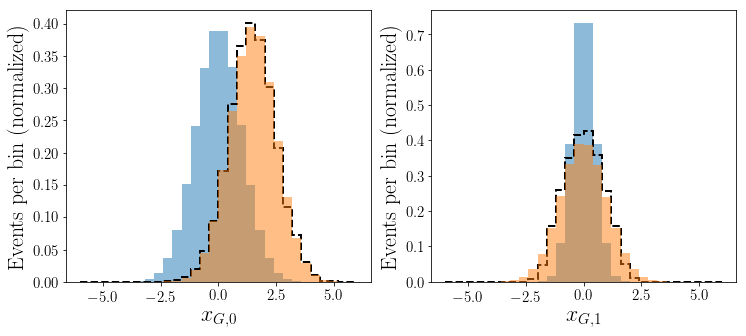

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

bins = np.linspace(-6, 6, 31)
ax[0].hist(X0_val_G[:, 0], bins=bins, label=r'$\mu={}$'.format(mu0), **plot_style_2)
ax[0].hist(X0_val_G[:, 0],
         bins=bins,
         label=r'$\mu=0$ DCTR wgt.',
         weights=weights, **plot_style_0)
ax[0].hist(X1_val_G[:, 0], bins=bins, label=r'$\mu={}$'.format(mu1), **plot_style_2)
ax[0].set_xlabel(r'$x_{G,0}$')
ax[0].set_ylabel("Events per bin (normalized)")

ax[1].hist(X0_val_G[:, 1], bins=bins, label=r'$\mu={}$'.format(mu0), **plot_style_2)
ax[1].hist(X0_val_G[:, 1],
         bins=bins,
         label=r'$\mu=0$ DCTR wgt.',
         weights=weights, **plot_style_0)
ax[1].hist(X1_val_G[:, 1], bins=bins, label=r'$\mu={}$'.format(mu1), **plot_style_2)
ax[1].set_xlabel(r'$x_{G,1}$')
ax[1].set_ylabel("Events per bin (normalized)")

fig.show()

### Validate for simulation-level

Detector effects are emulated by $X_S=X_{G,0}+Z$, where $Z\sim\mathcal{N}(4\lvert X_{G,1}\rvert,(X_{G,1})^2)$, where $4\lvert X_{G,1}\rvert$ represents some overall shifting bias and $(X_{G,1})^2$ represents an overall smearing bias. Importantly, the resolution depends on the secondary generator-level feature.

In [27]:
# Generate simulation-level by smearing generator-level

X0_val_S = np.array([(x[0] + np.random.normal(4*abs(x[1]), x[1]**2))
                         for x in X0_val_G])  # Detector smearing
X1_val_S = np.array([(x[0] + np.random.normal(4*abs(x[1]), x[1]**2))
                         for x in X1_val_G])  # Detector smearing

No handles with labels found to put in legend.
No handles with labels found to put in legend.


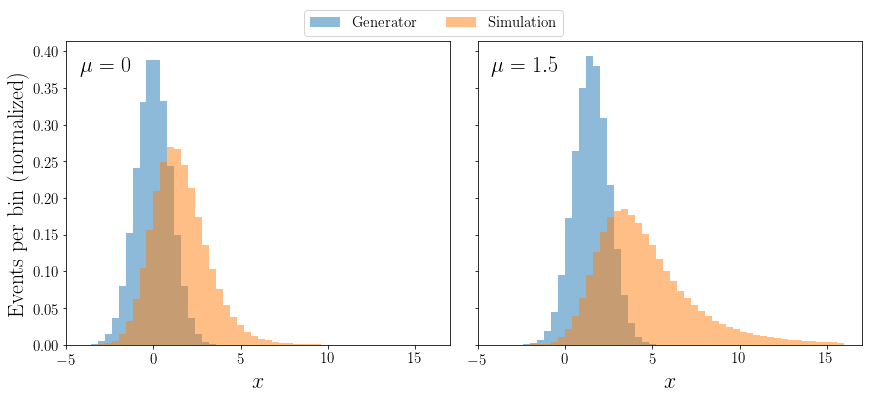

In [31]:
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

bins = np.linspace(-4, 16, 51)

ax[0].set_xlabel("$x$")
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(X0_val_G[:, 0], bins=bins, **plot_style_2)
ax[0].hist(X0_val_S, bins=bins, **plot_style_2)
ax[0].legend(title=r'$\mu={}$'.format(mu0), loc='upper left', frameon=False)

ax[1].set_xlabel("$x$")
ax[1].hist(X1_val_G[:, 0], bins=bins, **plot_style_2)
ax[1].hist(X1_val_S, bins=bins, **plot_style_2)
ax[1].legend(title=r'$\mu={}$'.format(mu1), loc='upper left', frameon=False)

handles = [Patch(facecolor='C0', alpha=0.5), Patch(facecolor='C1', alpha=0.5)]
labels = ['Generator', 'Simulation']
fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.66, 1.1))

fig.show()

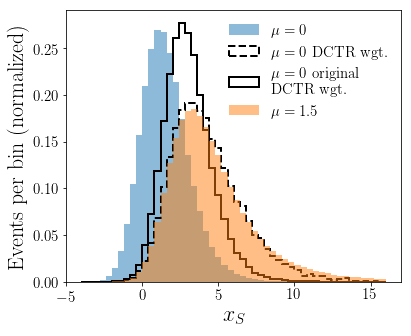

In [39]:
bins = np.linspace(-4, 16, 51)
plt.figure(figsize=(6,5))
plt.hist(X0_val_S, bins=bins, label=r'$\mu=0$', **plot_style_2)
plt.hist(X0_val_S,
         bins=bins,
         label=r'$\mu=0$ DCTR wgt.',
         weights=weights, **plot_style_0)

plt.hist(X0_val_S,
         bins=bins,
         label=r'$\mu=0$ original'+'\nDCTR wgt.',
         weights=weights_original, **plot_style_1)

plt.hist(X1_val_S, bins=bins, label=r'$\mu={}$'.format(mu1), **plot_style_2)

plt.legend(frameon=False)
plt.xlabel(r"$x_S$")
plt.ylabel("Events per bin (normalized)")
plt.show()

A demonstration of reweighting derived at generator-level  for  the  primary  generator-level  feature  (top),  the  secondary generator-level feature (middle), and simulation-level(bottom).  In the bottom plot, a reweighting using only theprimary  generator  feature  is  also  shown  (labeled  ‘Original’ DCTR wgt.)